2024-02-19 13:34:20.487917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 13:34:20.487944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 13:34:20.489110: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 13:34:20.495489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 13:34:21.189766: W tensorflow/compiler/tf2

In [1]:
import tensorflow as tf
import pandas as pd

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from utils.helper import *
from utils.constants import *
from inception.main import build_model

df = read_dataset("ArrowHead")

X_train = df[0].reshape(df[0].shape[0], df[0].shape[1], 1)
X_test = df[2].reshape(df[2].shape[0], df[2].shape[1], 1)
# apply one-hot encoder
y_train=to_categorical(df[1])
y_test=to_categorical(df[3])

model = build_model(input_shape=X_train.shape[1:] , num_classes=y_train.shape[1], num_modules=1)
model.summary()

2024-02-19 14:21:46.975555: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 14:21:46.975581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 14:21:46.976553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 14:21:46.982848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 14:21:47.723419: W tensorflow/compiler/tf2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 251, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 251, 32)              32        ['input_1[0][0]']             
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 251, 1)               0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 251, 32)              10240     ['conv1d[0][0]']          

2024-02-19 14:21:48.764156: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 14:21:48.800394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 14:21:48.800622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

test (36, 251, 1)
Epoch 1/1000


2024-02-19 14:22:02.369805: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-19 14:22:03.942363: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3e1c8aa940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 14:22:03.942386: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P400, Compute Capability 6.1
2024-02-19 14:22:03.947474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708348924.015430  103120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 7s 1s/step - loss: 1.5932 - accuracy: 0.1667 - val_loss: 1.4130 - val_accuracy: 0.3943 - lr: 0.0100
Epoch 2/1000
3/3 [==============================] - 0s 60ms/step - loss: 1.0966 - accuracy: 0.4722 - val_loss: 1.1076 - val_accuracy: 0.3086 - lr: 0.0100
Epoch 3/1000
3/3 [==============================] - 0s 61ms/step - loss: 1.1621 - accuracy: 0.3333 - val_loss: 1.2620 - val_accuracy: 0.3029 - lr: 0.0100
Epoch 4/1000
3/3 [==============================] - 0s 58ms/step - loss: 1.2147 - accuracy: 0.3889 - val_loss: 1.2676 - val_accuracy: 0.3029 - lr: 0.0100
Epoch 5/1000
3/3 [==============================] - 0s 57ms/step - loss: 1.1281 - accuracy: 0.3333 - val_loss: 1.1411 - val_accuracy: 0.3943 - lr: 0.0100
Epoch 6/1000
3/3 [==============================] - 0s 55ms/step - loss: 1.0750 - accuracy: 0.3056 - val_loss: 1.5429 - val_accuracy: 0.3943 - lr: 0.0100
Epoch 7/1000
3/3 [==============================] - 0s 57ms/step - loss: 1.0959 - accuracy:

FileNotFoundError: [Errno 2] No such file or directory: 'compare/ArrowHead.png'

<Figure size 640x480 with 0 Axes>

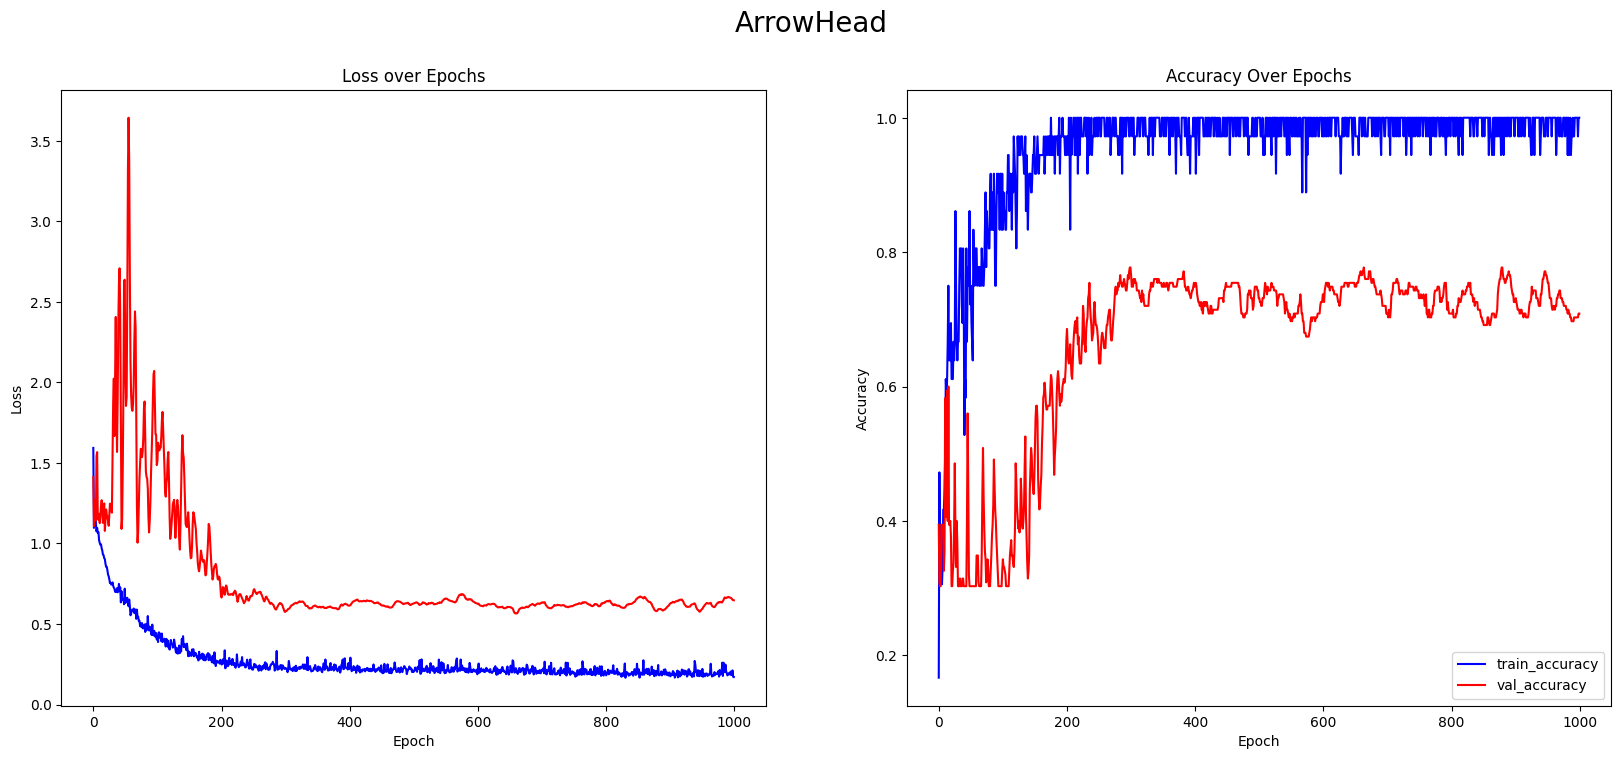

In [2]:
results=[]
histories=[]

try:
    for dataset in  ['ArrowHead', 'Wine', 'OliveOil', 'Car', 'BeetleFly']:
        with tf.device("/device:GPU:0"):
            # Load data
            df = read_dataset(dataset)

            X_train = df[0].reshape(df[0].shape[0], df[0].shape[1], 1)
            X_test = df[2].reshape(df[2].shape[0], df[2].shape[1], 1)

            # apply one-hot encoder
            y_train=to_categorical(df[1])
            y_test=to_categorical(df[3])
            print("test",X_train.shape)

            # Compile the model
            model = build_model(input_shape=X_train.shape[1:] , num_classes=y_train.shape[1], num_modules=1)

            callbacks =[
                tf.keras.callbacks.ModelCheckpoint(
                    f"best_models/best_model_{dataset}.tf", save_weights_only=True, monitor="lr"
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor="lr", factor=0.5, patience=50, min_lr=0.0001
                ),
            ]

            # Train the model
            history = model.fit(X_train, y_train, batch_size=16, epochs=1000, validation_data= (df[2], y_test), callbacks = callbacks)

            # Evaluate the model
            train_loss, train_accuracy = model.evaluate(X_train, y_train)
            test_loss, test_accuracy = model.evaluate(X_test, y_test)

            results.append([dataset, train_loss, train_accuracy, test_loss, test_accuracy])
            histories.append(history.history)
            
    pd.DataFrame(results, columns=["Dataset","Train loss", "Train accuracy","Test loss", "Test accuracy"]).to_csv("result.csv", index=False)

except Exception as e:
    print("An error occurred:", e)


for i in range(len(histories)):
    plot_loss(histories[i], UNIVARIATE_DATASET_NAMES_2018[i])

In [3]:
for i in range(len(histories)):
    plot_loss(histories[i], UNIVARIATE_DATASET_NAMES_2018[i])

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>